In [1]:
%load_ext autoreload
%autoreload 2

In [98]:
!jupyter-nbconvert --to python --template python_clean newyorker.ipynb

[NbConvertApp] Converting notebook newyorker.ipynb to python
[NbConvertApp] Writing 4234 bytes to newyorker.py


In [2]:
import logging

In [3]:
from random import randrange
from datetime import datetime
from pathlib import Path

In [4]:
import constants
import feedparser
import requests

In [8]:
# two different import modes for development or distribution
try:
    # import from other modules above this level
    from . import layout
    from . import constants
except ImportError:
    import constants
    # development in jupyter notebook
    import layout

In [35]:
def update_function(self, day_range=5):
    '''update function for newyorker provides a New Yorker comic of the day
    
    This plugin provides an image and text pulled from the New Yorker 
    
    Requirments:
        self.config(dict): {
            'day_range': 'number of days to pull comics from (default: 5)',
        }    
    
    Args:
        self(`namespace`)
        day_range(`int`): number of days in the past to pull radom comic and text from
            use 1 to only pull from today
        
    Returns:
        tuple: (is_updated(bool), data(dict), priority(int))    
    %U'''
    def time_now():
        return datetime.now().strftime("%H:%M")

    def fetch_comic(day_range=1):
        '''pull a feed from the New Yorker and choose an comic at random from the specified range
        
             cache the image to show again later to limit network trafic
             
        Args:
            day_range(int): number of days to choose from (use 1 for today only)
            
        Returns:
            tuple: (bool, dict) - True if successful, dictionary of comic, caption and time'''
       # set up the feed parser and fetch the feed
        feed = feedparser.parse(constants.feed_url)
        if feed.has_key('bozo_exception'):
            logging.warning(f'could not fetch feed for {constants.feed_url}')
            # bail out if there was an error
            return(False, {})

        if day_range > len(feed.entries):
            day_range = len(feed.entries)
            logging.warning(f'day_range set to a value larger than the number of entries returned by the feed. Setting to: {day_range} ')        

        choice = randrange(0, day_range)

        try:
            comic_caption = feed.entries[choice].summary
            comic_url = feed.entries[choice].media_thumbnail[0]['url']
            comic_id = feed.entries[choice].id
        except IndexError as e:
            logging.warning(f'no valid data was returned in the feed: {e}')        
            return(False, {})
        except KeyError as e:
            logging.warning(f'no url was found under the `media_thumbnail`: {e}')
            return(False, ())

        comic_image = self.cache.cache_file(comic_url, comic_id)

        return(True, {'comic': comic_image, 
                      'caption': comic_caption, 
                      'time': time_now()})    
    
    
    is_updated = True
    data = {'comic': Path(constants.images_path)/'shruggy.jpg',
            'caption': f'Could not load a comic. Are the Inter-Tubes clogged?',
            'time': time_now()
            }
    priority = self.max_priority
    
    success, my_data = fetch_comic(day_range)
    if success:
        data.update(my_data)
    
    return (is_updated, data, priority) 

In [17]:
# because I can't figure out relative imports in python 3 & Jupyter, here's some 
# nb magic that makes testing the update_function easier with the SelfDummy class
!ln -s ../../library/SelfDummy.py ./
!ln -s ../../library/CacheFiles.py ./
!ln -s ../../library ./

ln: failed to create symbolic link './SelfDummy.py': File exists
ln: failed to create symbolic link './CacheFiles.py': File exists
ln: failed to create symbolic link './library': File exists


In [53]:
# logger = logging.getLogger(__name__)
# logger.root.setLevel('INFO')

In [83]:
# from library.CacheFiles import CacheFiles
# # def test_plugin():
# '''This code snip is useful for testing a plugin from within Jupyter Notebook'''
# from library import Plugin
# from IPython.display import display
# # this is set by PaperPi based on the configured screen
# test_plugin = Plugin(resolution=(1200, 800))
# # this is pulled from the configuration file; the appropriate section is passed
# # to this plugin by PaperPi during initial configuration
# test_plugin.config = {'your_name': 'Aaron', 'favorite_color': 'pink'}
# test_plugin.layout = layout.layout
# # this is done automatically by PaperPi when loading the plugin
# test_plugin.cache = CacheFiles()
# test_plugin.update_function = update_function
# test_plugin.refresh_rate = 1
# # display(test_plugin.image)
# # return test_plugin
# # my_plugin = test_plugin

INFO:root:section: [............comic.............]
INFO:root:section: [...........caption............]
INFO:root:section: [.............time.............]
INFO:root:setting blocks
INFO:root:section: [............comic.............]
INFO:root:set image block: comic
INFO:root:section: [...........caption............]
INFO:root:set text block: caption
INFO:root:section: [.............time.............]
INFO:root:set text block: time
INFO:root:section: [............comic.............]
INFO:root:section: [...........caption............]
INFO:root:section: [.............time.............]
INFO:root:setting blocks
INFO:root:section: [............comic.............]
INFO:root:set image block: comic
INFO:root:section: [...........caption............]
INFO:root:set text block: caption
INFO:root:section: [.............time.............]
INFO:root:set text block: time


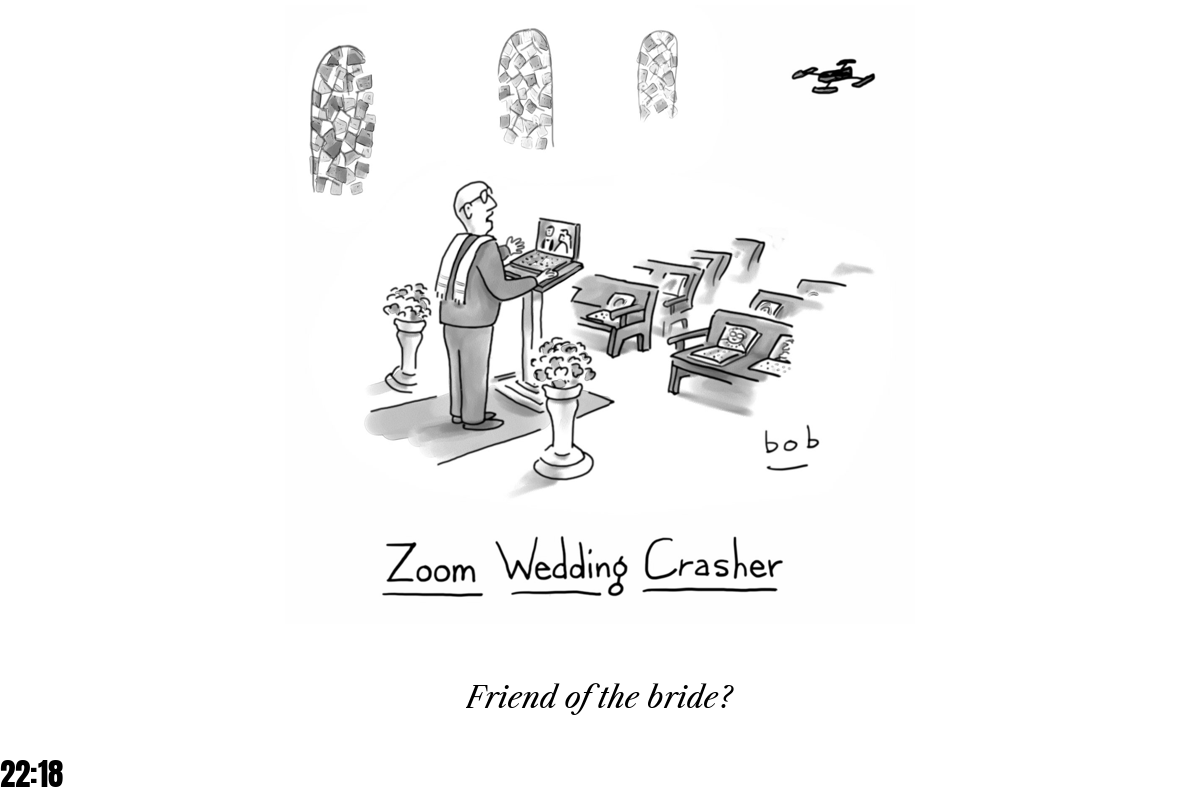

In [94]:
# test_plugin.update()
# test_plugin.image

In [97]:
!rm ./SelfDummy.py
!rm ./library

rm: cannot remove './SelfDummy.py': No such file or directory
rm: cannot remove './library': No such file or directory
